# Interactive Analysis
One need for bioimage analysts is to interactivly perform analysis on images. This interaction could be manual parameter tuning, such as adjusting thresholds, or performing human-in-the-loop analysis through clicking on specific regions of an image.

**[napari](https://napari.org/)** makes such interactive analyses easy because of it's easy coupling with Python and Scientific Python ecosystem, including tools like **[numpy](https://numpy.org/)** and **[scikit-image](https://scikit-image.org/)**.

## Setup

In [1]:
# this cell is required to run these notebooks on Binder
# if running on Binder, remember to **WAIT 5 SECONDS** after
# running the '%gui qt' cell below. If you get an error,
# click on "Kernel -> Restart" and try again. Make sure also
# that you have a desktop tab open.
import os
if 'BINDER_SERVICE_HOST' in os.environ:
    os.environ['DISPLAY'] = ':1.0'

As was explained in the image visaulation tutorial, napari uses Qt for Graphical User Interface (GUI) so we must first create the Qt application before we can get started with `napari`.

In [2]:
%gui qt

We can then import `napari`, our `nbscreenshot` utility and instantiate an empty viewer.

In [3]:
import napari
from napari.utils import nbscreenshot

# Create an empty viewer
viewer = napari.Viewer()

Let's read the original image from previous lessons, take a maximum projection, and view it in napari:

In [4]:
from tifffile import imread

# load the image data and inspect its shape
nuclei_mip = imread('data/nuclei.tif').max(axis=0)
print(nuclei_mip.shape)

(256, 256)


In [5]:
viewer.add_image(nuclei_mip);

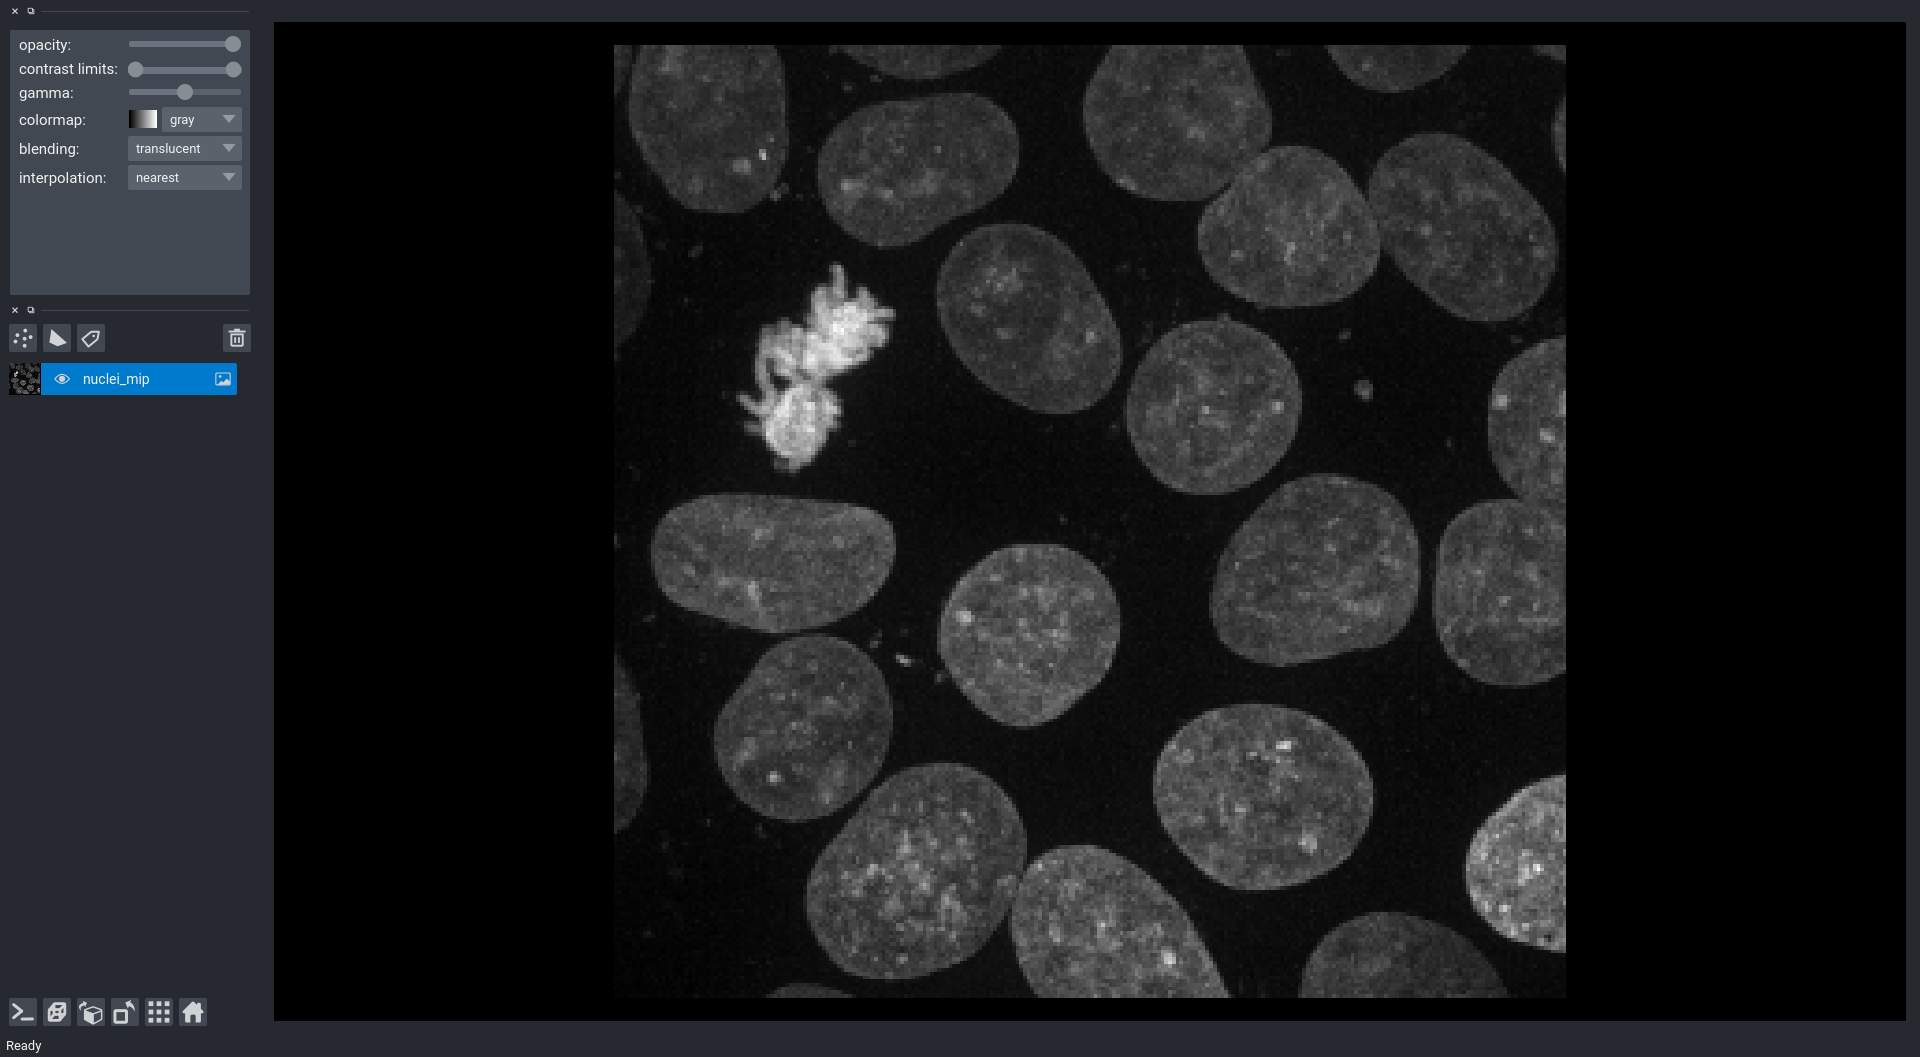

In [6]:
nbscreenshot(viewer)

## Visualizing image filtering results

One common task in image processing in **image filtering** which can be used to denoise an image or detect edges or other features.

We can use **napari** to visualize the results of some of the image filters that come with the **scikit-image** library.

In [7]:
# Import scikit-image's filtering module
from skimage import filters

In [8]:
viewer.add_image(filters.sobel_h(nuclei_mip), name='Horizontal Sobel');
viewer.add_image(filters.sobel_v(nuclei_mip), name='Vertical Sobel');
viewer.add_image(filters.roberts(nuclei_mip), name='Roberts');
viewer.add_image(filters.prewitt(nuclei_mip), name='Prewitt');
viewer.add_image(filters.scharr(nuclei_mip), name='Scharr');

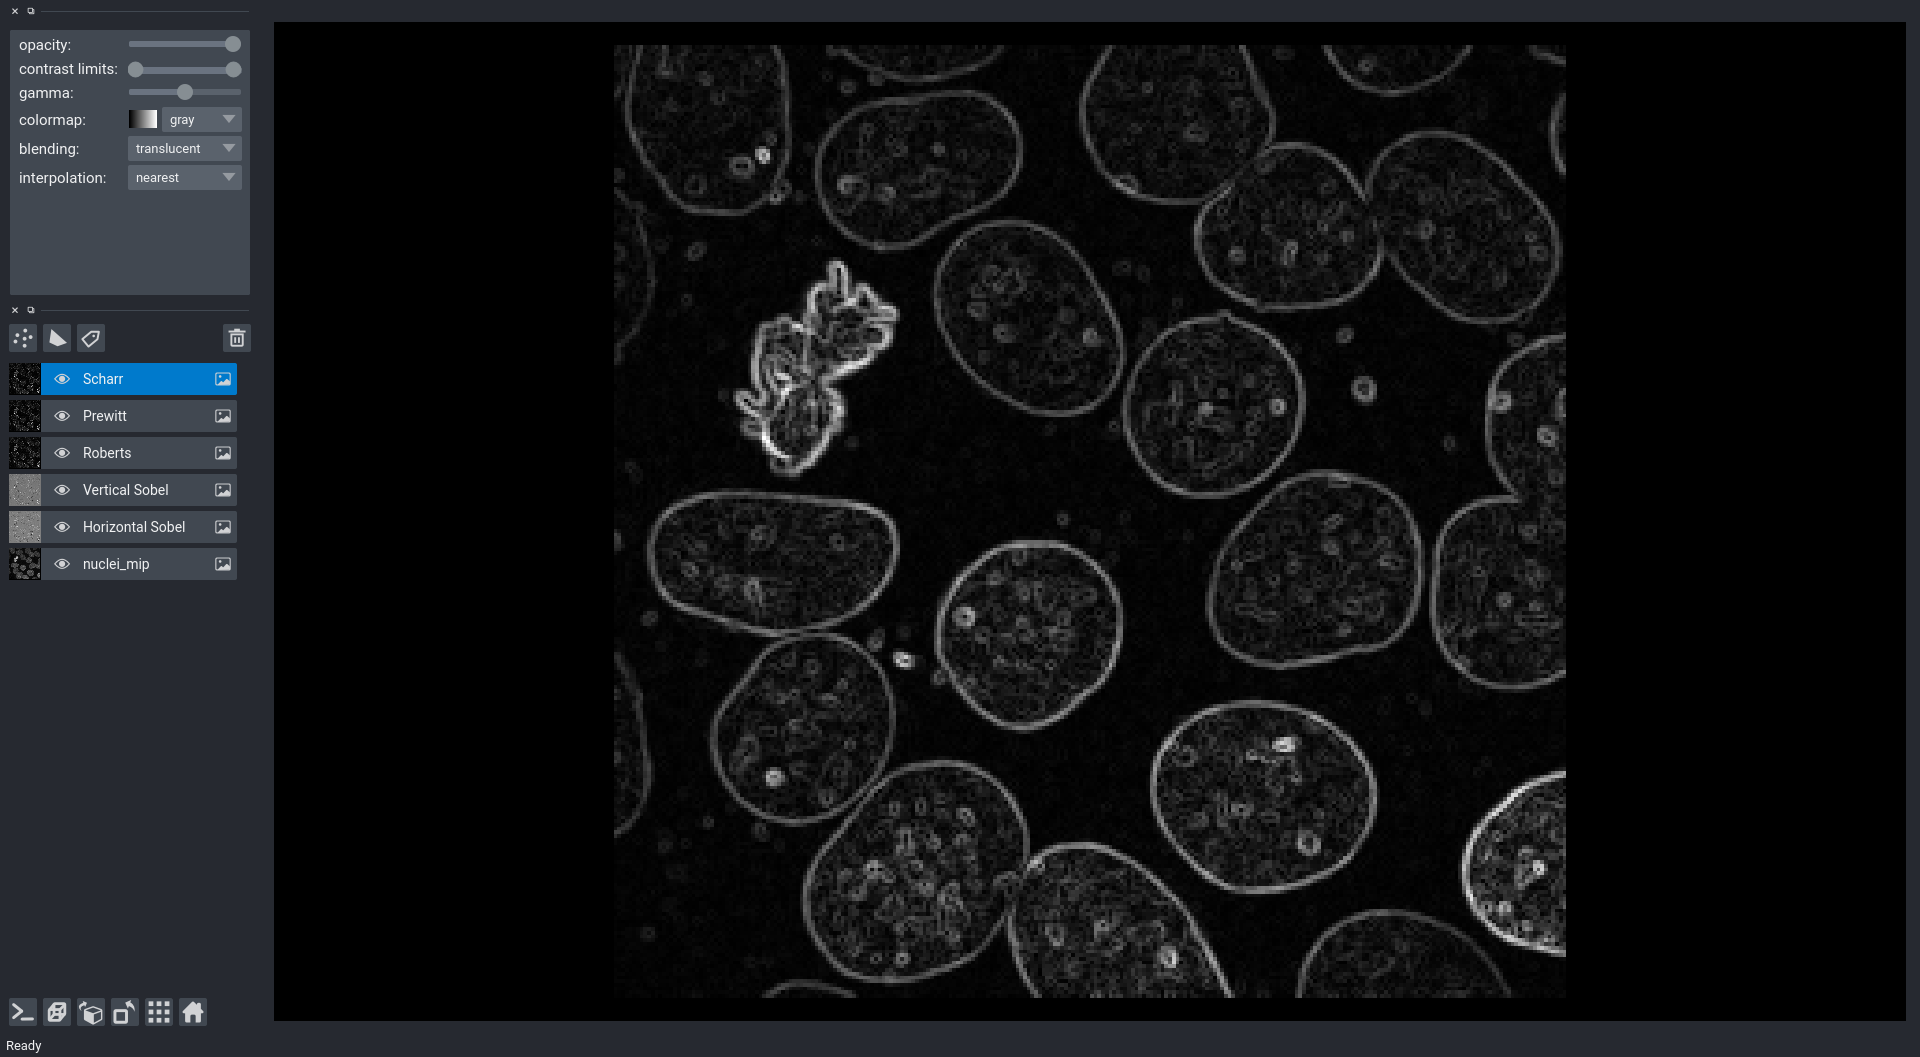

In [9]:
nbscreenshot(viewer)

In [10]:
# Remove all filter layers
for l in viewer.layers[1:]:
    viewer.layers.remove(l)

## Interactive segmentation

Let's now perform an interactive segmentation of the nuclei using processing utilities from scikit-image.

In [11]:
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import segmentation
from scipy import ndimage
import numpy as np

First let's try and seperate background from foreground using a threhold. Here we'll use an automatically calculated threshold.

In [12]:
foreground = nuclei_mip >= filters.threshold_li(nuclei_mip)
viewer.add_labels(foreground);

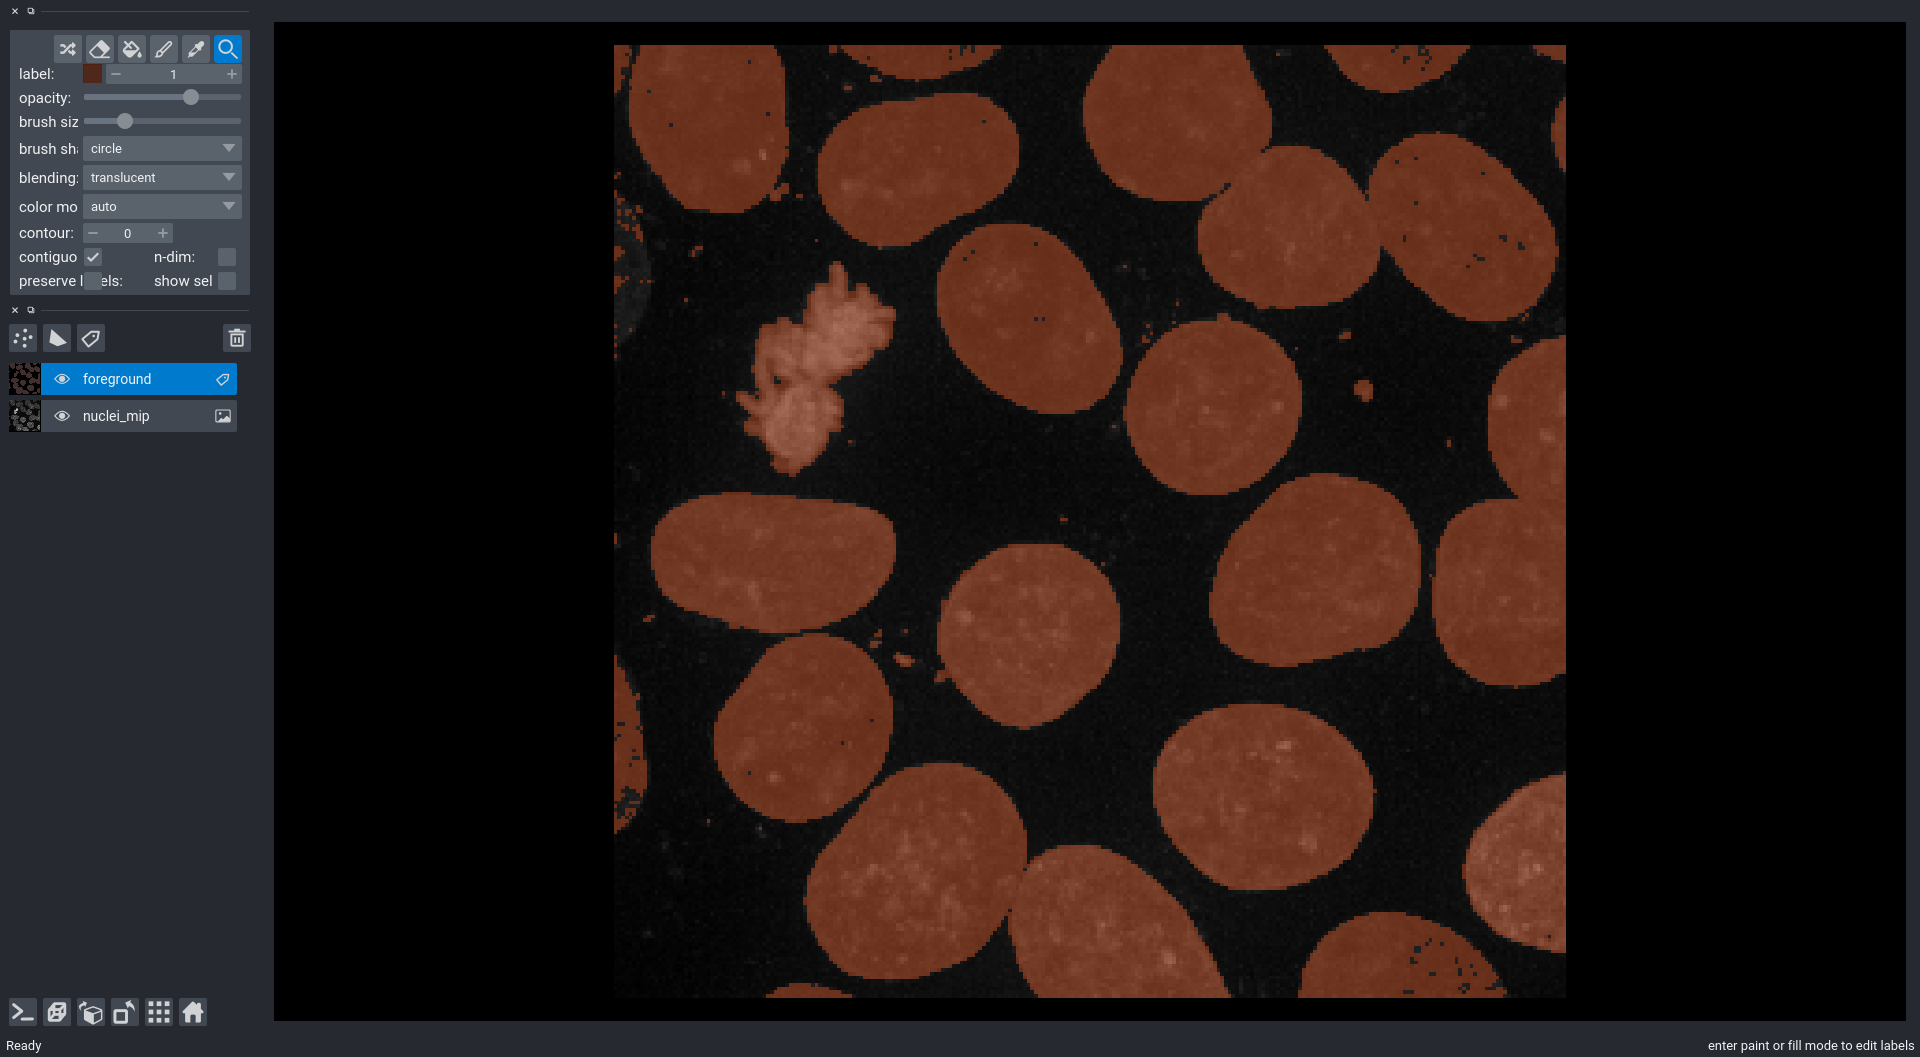

In [13]:
nbscreenshot(viewer)

Notice the debris located outside the nuclei and some of the holes located inside the nuclei. We will remove the debris by filtering out small objects, and fill the holes using a hole filling algorithm. We can update the data in the viewer in place.

In [14]:
foreground_processed = morphology.remove_small_holes(foreground, 60)
foreground_processed = morphology.remove_small_objects(foreground_processed, min_size=50)

viewer.layers['foreground'].data = foreground_processed

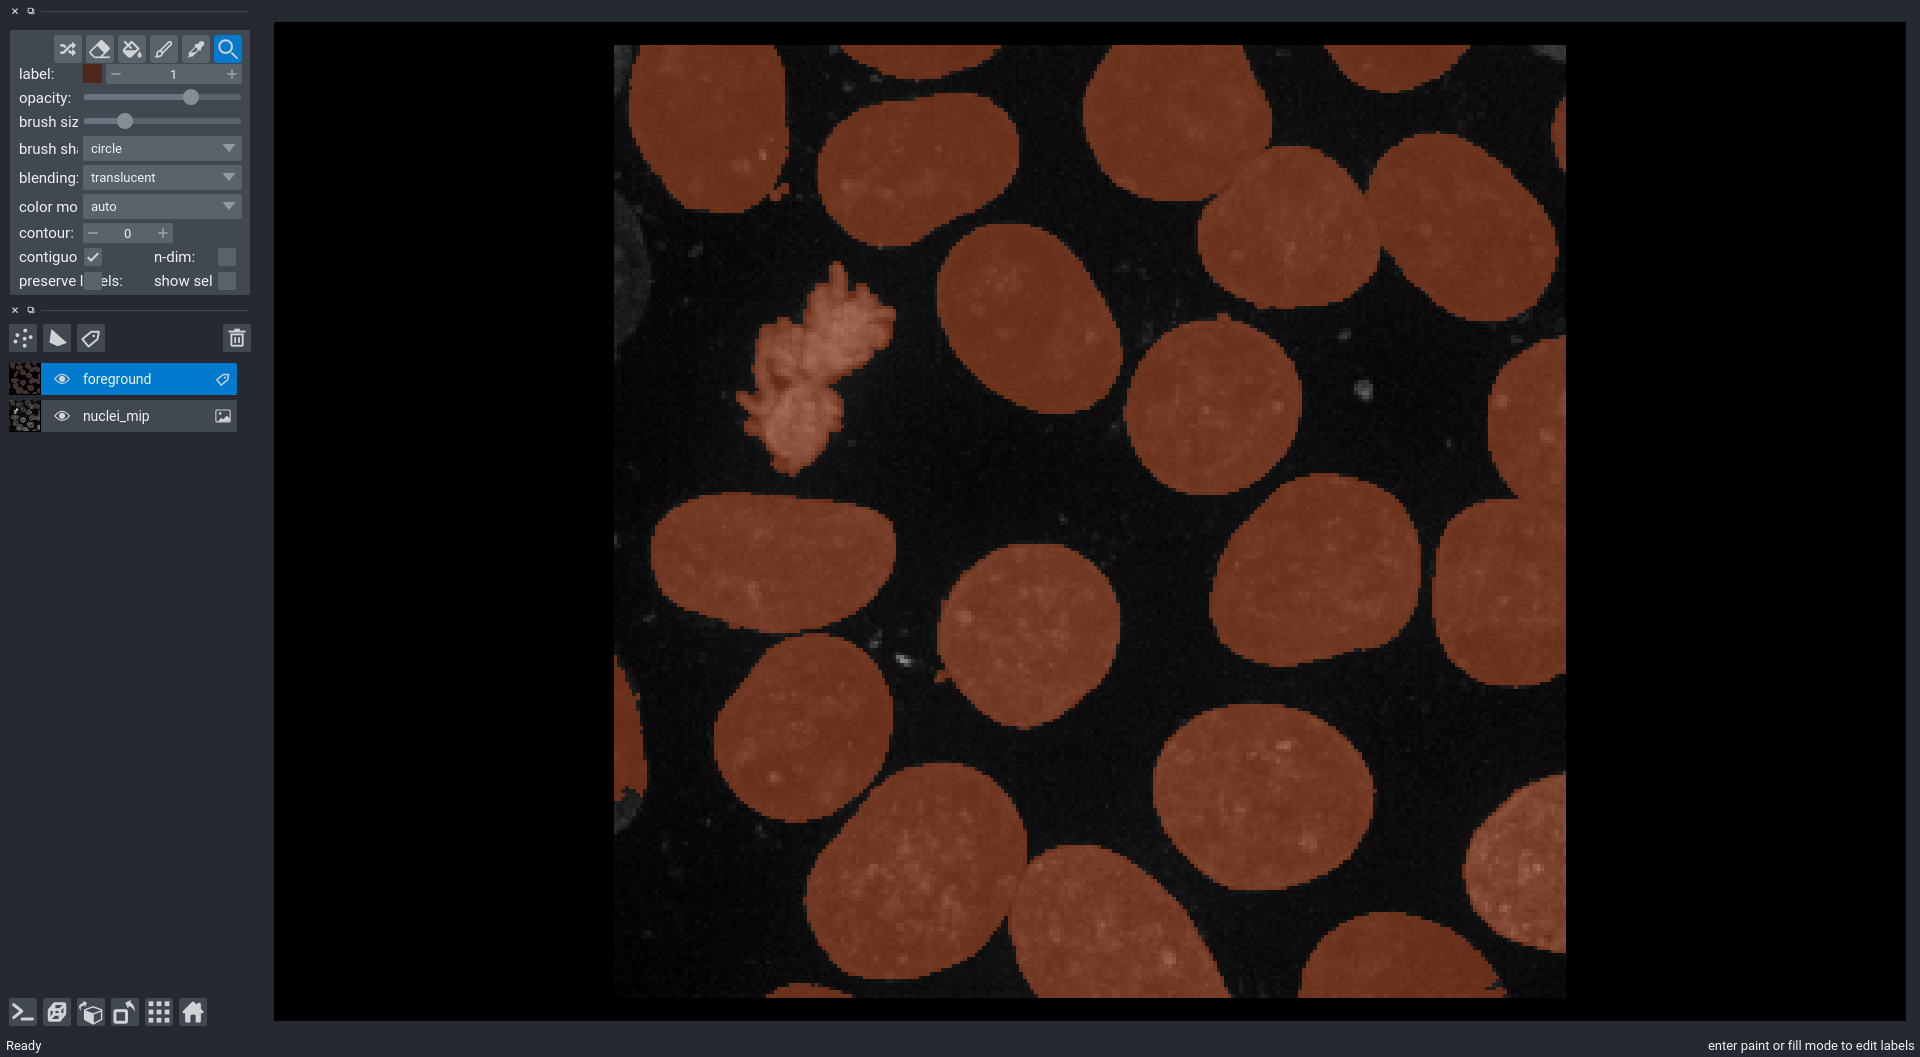

In [15]:
nbscreenshot(viewer)

We will now convert this binary mask into an **instance segmentation** where each nuclei is assigned a unique label.

We will do this using a **marker controlled watershed** approach. The first step in this procedure is to calculate a distance transform on the binary mask as follows.

In [16]:
distance = ndimage.distance_transform_edt(foreground_processed)
viewer.add_image(distance);

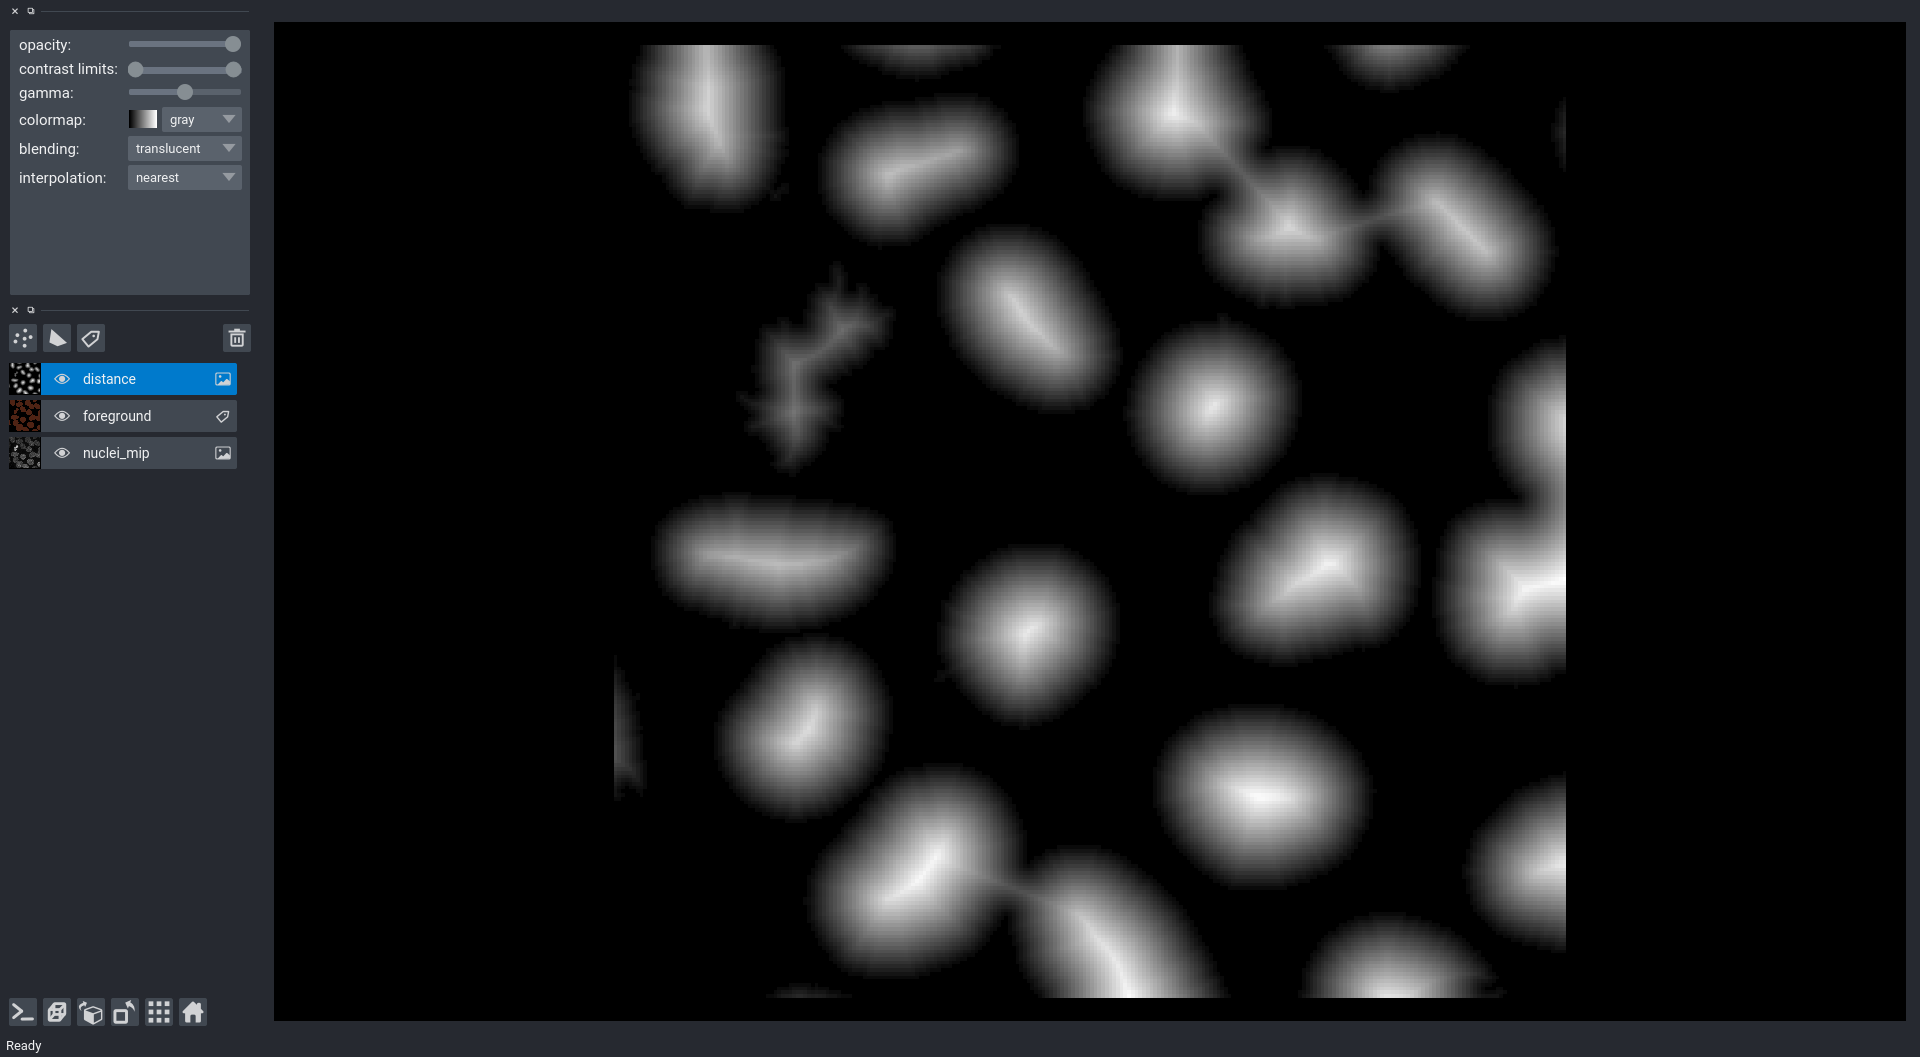

In [17]:
nbscreenshot(viewer)

We'll actually want to smooth the distance transform to avoid over segmentation artifacts. We can do this on the data in the viewer in place.

In [18]:
smoothed_distance = filters.gaussian(distance, 10)
viewer.layers['distance'].data = smoothed_distance

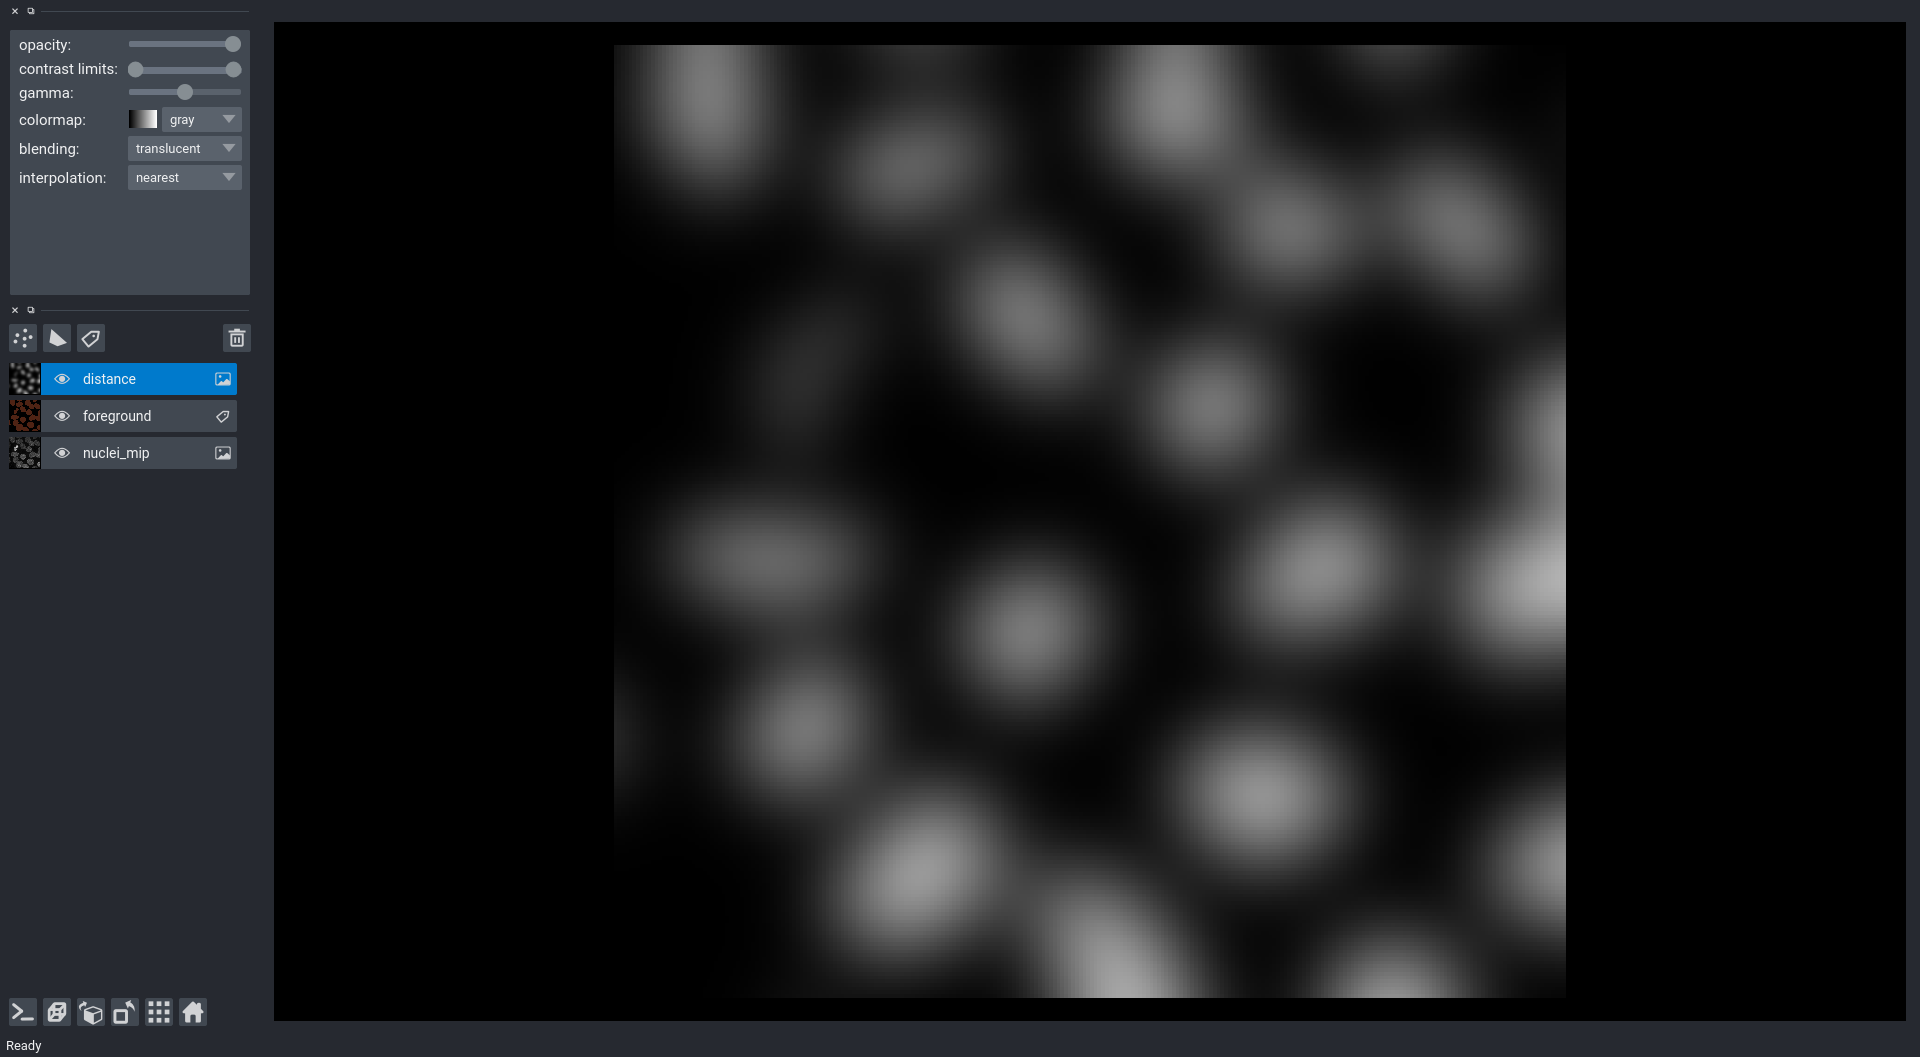

In [19]:
nbscreenshot(viewer)

Now we can try and identify the centers of each of the nuclei by finding peaks of the distance transform 

In [20]:
peak_local_max = feature.peak_local_max(
    smoothed_distance,
    footprint=np.ones((7, 7), dtype=np.bool),
    indices=False,
    labels=measure.label(foreground_processed)
)
peaks = np.nonzero(peak_local_max)

<ipython-input-20-bb62bc05e5fe>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  footprint=np.ones((7, 7), dtype=np.bool),
<ipython-input-20-bb62bc05e5fe>:1: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_local_max = feature.peak_local_max(


In [21]:
viewer.add_points(np.array(peaks).T, name='peaks', size=5, face_color='red');

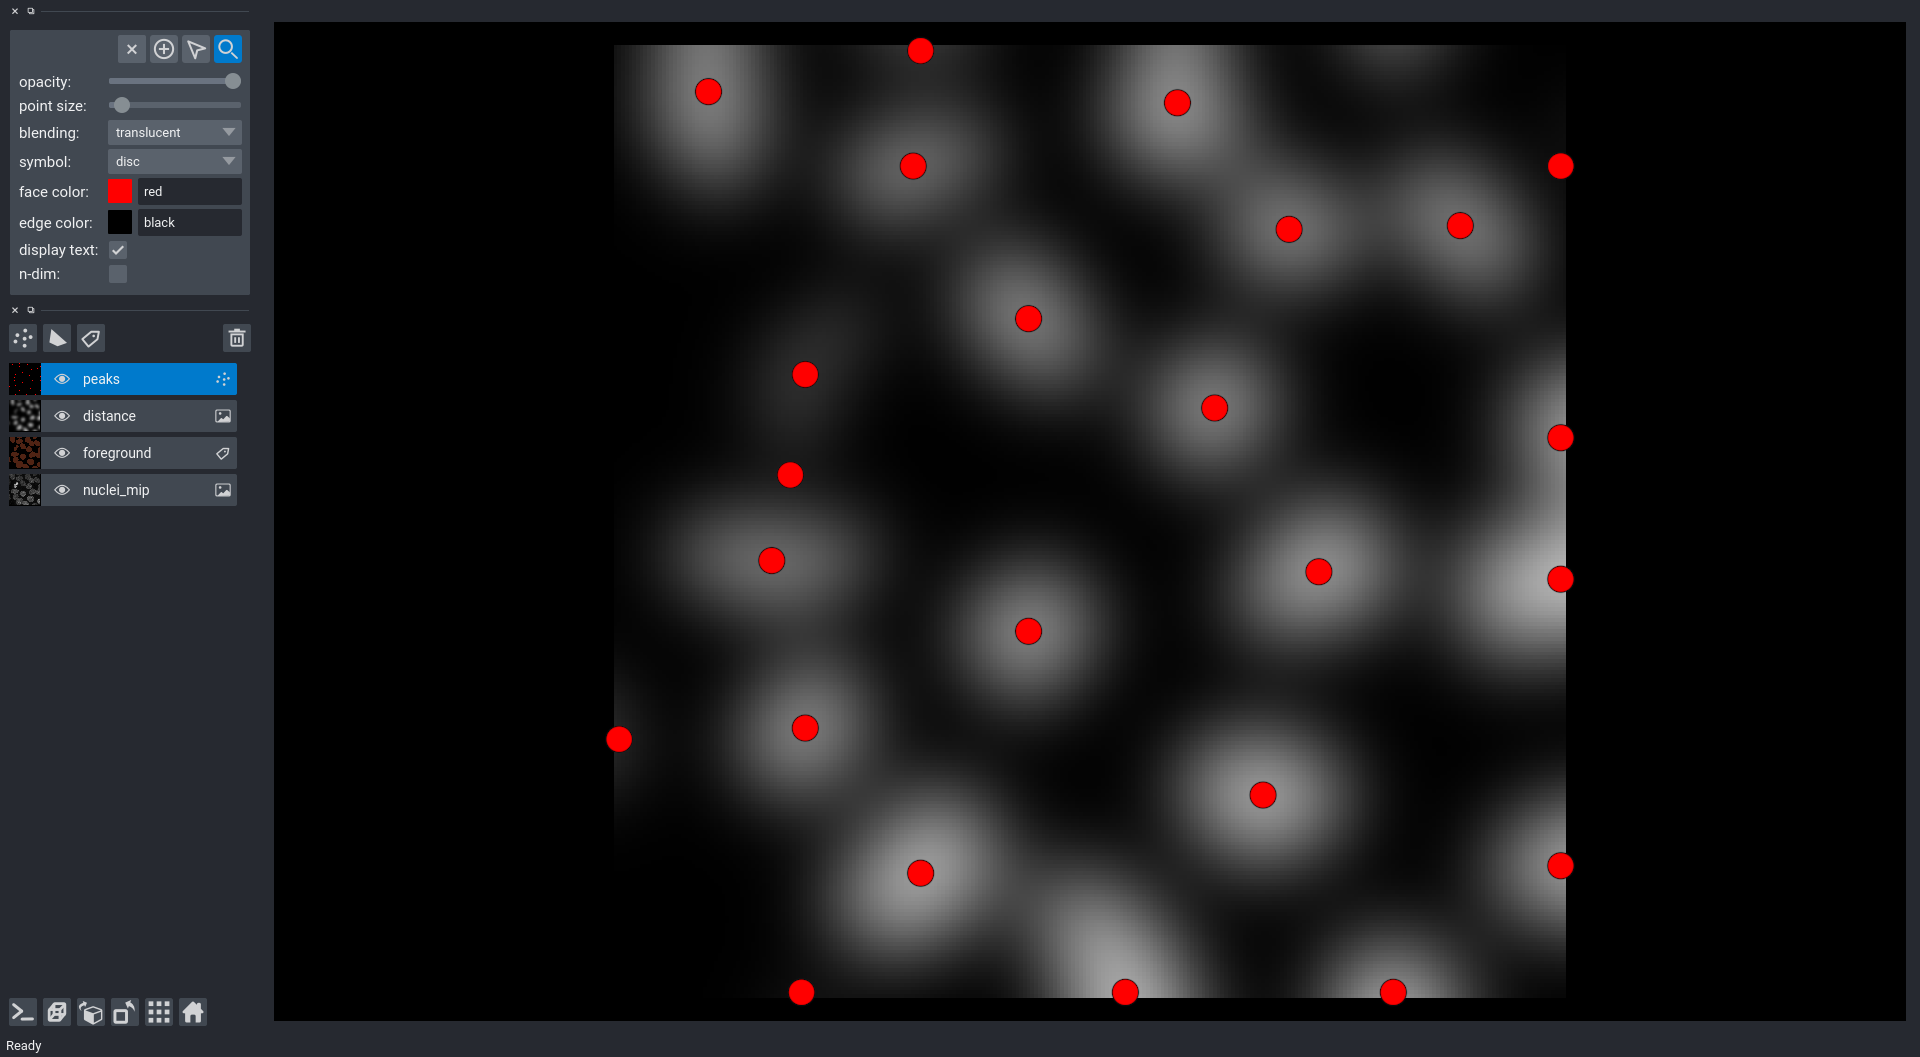

In [22]:
nbscreenshot(viewer)

We can now remove any of the points that don't correspond to nuclei centers or add any new ones using the GUI.

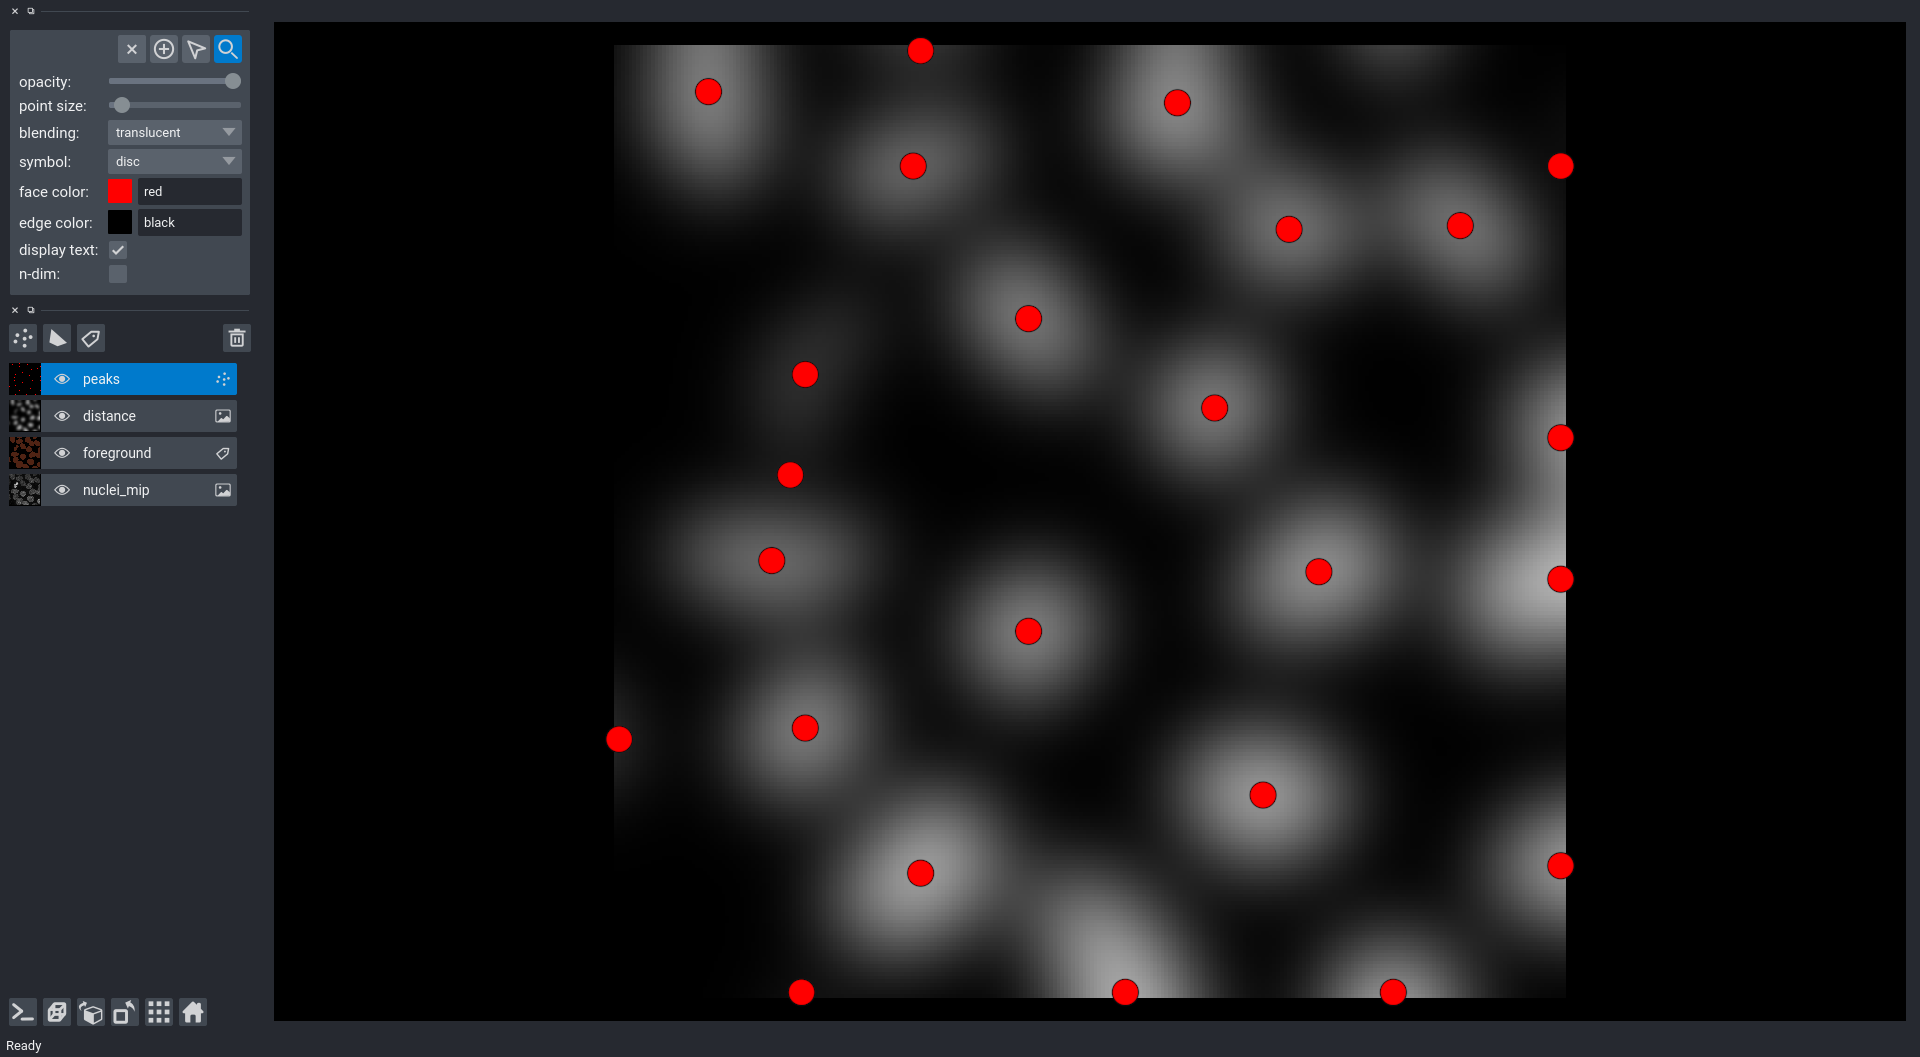

In [23]:
nbscreenshot(viewer)

Based on those peaks we can now seed the watershed algorithm which will find the nuclei boundaries.

In [24]:
new_peaks = np.round(viewer.layers['peaks'].data).astype(int).T
seeds = np.zeros(nuclei_mip.shape, dtype=bool)
seeds[(new_peaks[0], new_peaks[1])] = 1

markers = measure.label(seeds)
nuclei_segmentation = segmentation.watershed(
    -smoothed_distance, 
    markers, 
    mask=foreground_processed
)

viewer.add_labels(nuclei_segmentation);

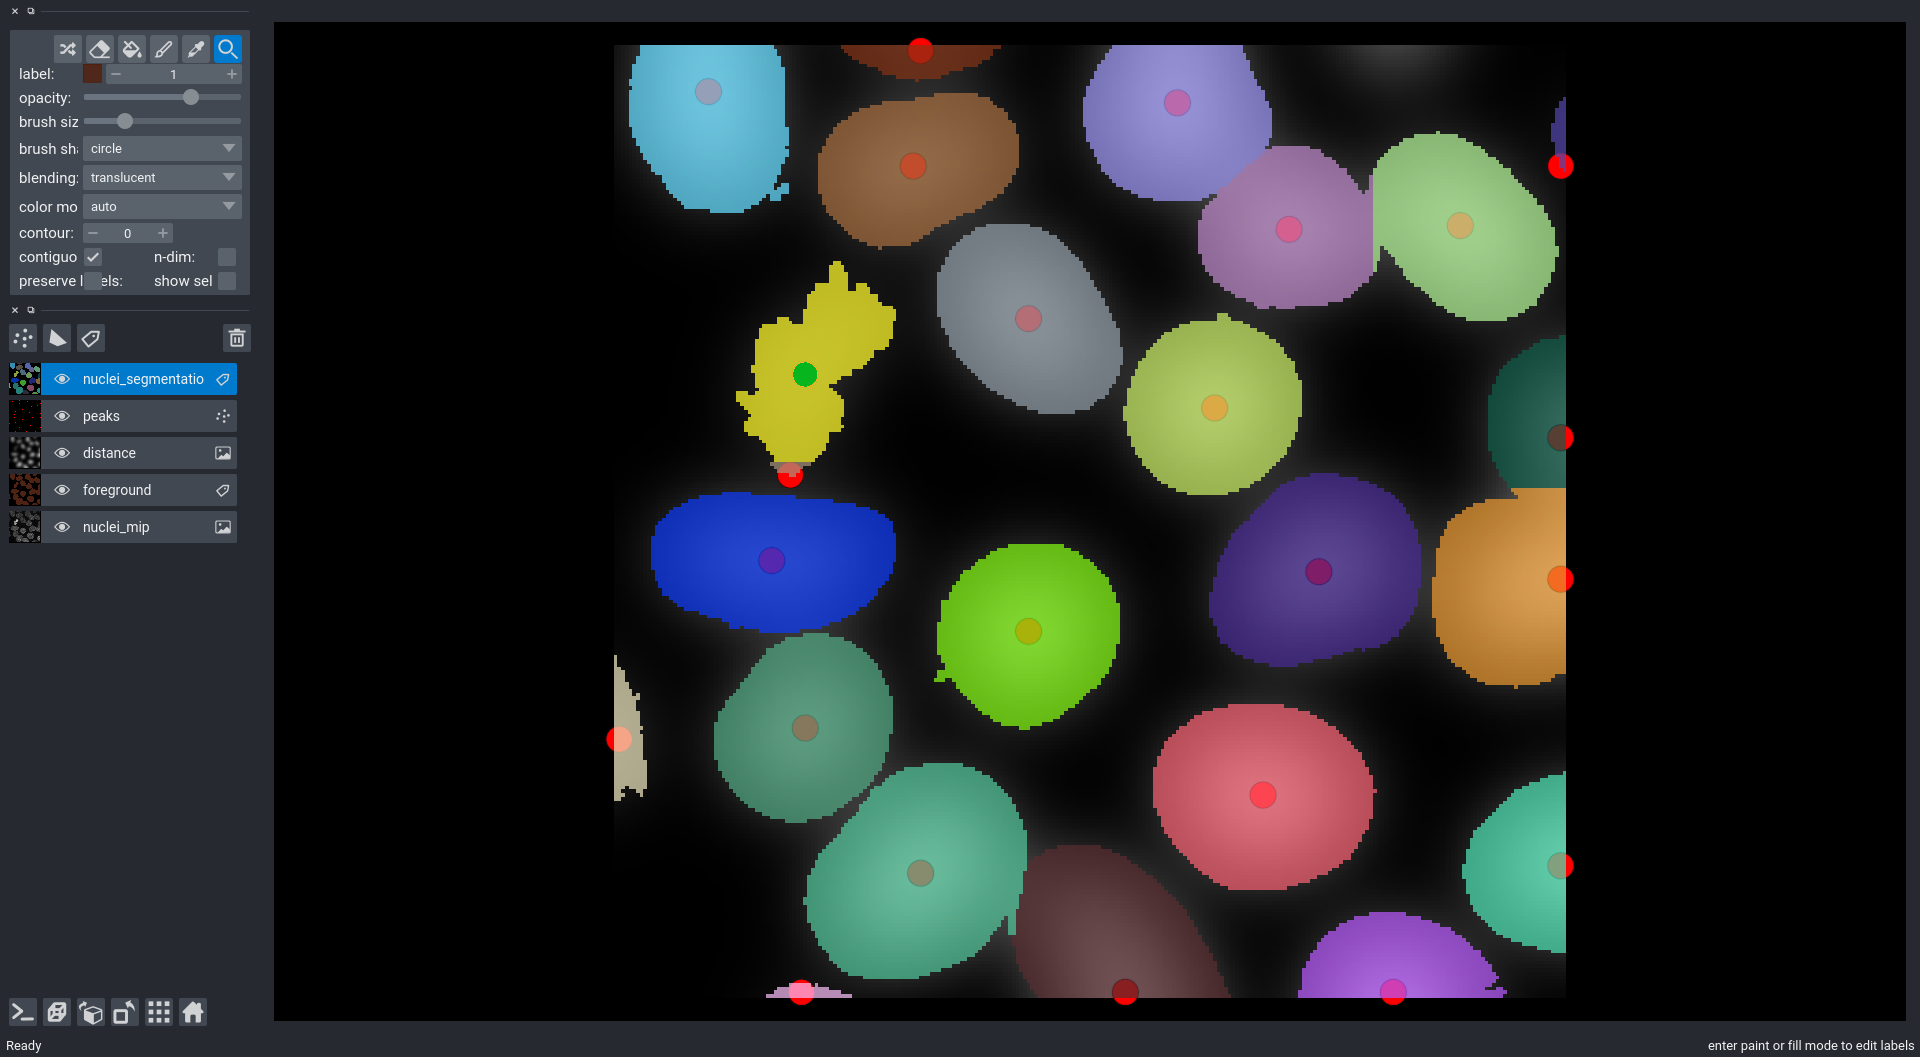

In [25]:
nbscreenshot(viewer)

We can now save our segmentation using our builtin save method.

In [26]:
viewer.layers['nuclei_segmentation'].save('nuclei-automated-segmentation.tif', plugin='builtins');

## Interactive thresholding with a custom GUI element

Interactivity can be greatly enhanced by custom GUI elements like slides and push buttons, custom mouse functions, or custom keybindings. **[napari](https://napari.org/)** can easliy be exteneded with these features, and a companion library **[magicgui](https://magicgui.readthedocs.io/en/latest/)** maintained by the napari team allows users to make extensions to the GUI without having to write any GUI code.

We'll now explore adding such interactivty to **napari**.

In [27]:
# Remove all processed layers
for l in viewer.layers[1:]:
    viewer.layers.remove(l)

In [43]:
# Import magicgui and qt functionality
from qtpy.QtWidgets import QSlider
from qtpy.QtCore import Qt
from magicgui import magicgui

@magicgui(b={'widget_type': 'Slider', 'min': 10, 'max': 20})
def add(a: int, b: int = 15) -> int:
    return a + b

# add.show()

In [44]:
from enum import Enum

import numpy
import napari
from napari.layers import Image

from magicgui import magicgui

class Operation(Enum):
    """A set of valid arithmetic operations for image_arithmetic.

    To create nice dropdown menus with magicgui, it's best
    (but not required) to use Enums.  Here we make an Enum
    class for all of the image math operations we want to
    allow.
    """
    add = numpy.add
    subtract = numpy.subtract
    multiply = numpy.multiply
    divide = numpy.divide


with napari.gui_qt():
    # create a viewer and add a couple image layers
    viewer = napari.Viewer()
    viewer.add_image(numpy.random.rand(20, 20), name="Layer 1")
    viewer.add_image(numpy.random.rand(20, 20), name="Layer 2")

    # here's the magicgui!  We also use the additional
    # `call_button` option
    @magicgui(call_button="execute")
    def image_arithmetic(
        layerA: Image, operation: Operation, layerB: Image
    ) -> Image:
        """Add, subtracts, multiplies, or divides to image layers."""
        return operation.value(layerA.data, layerB.data)

    # add our new magicgui widget to the viewer
    viewer.window.add_dock_widget(image_arithmetic)

    # keep the dropdown menus in the gui in sync with the layer model
    viewer.layers.events.inserted.connect(image_arithmetic.reset_choices)
    viewer.layers.events.removed.connect(image_arithmetic.reset_choices)

In [40]:
@magicgui(auto_call=True,
          percentile={'widget_type': 'Slider', 'minimum': 0, 'maximum': 100})
def threshold(layer: napari.layers.Image, percentile: int = 50) -> napari.layers.Labels:
    data_min = layer.data.min()
    data_max = layer.data.max()
    return layer.data > data_min + percentile / 100 * (data_max - data_min)

/home/loaloa/programs/anaconda3/envs/napari/lib/python3.9/site-packages/magicgui/widgets/_bases/ranged_widget.py:28: FutureWarning: The 'maximum' keyword arguments has been changed to 'max'. In the future this will raise an exception

  warn(
/home/loaloa/programs/anaconda3/envs/napari/lib/python3.9/site-packages/magicgui/widgets/_bases/ranged_widget.py:28: FutureWarning: The 'minimum' keyword arguments has been changed to 'min'. In the future this will raise an exception

  warn(


In [41]:
viewer.window.add_dock_widget(threshold.Gui());

AttributeError: 'FunctionGui' object has no attribute 'Gui'

In [ ]:
nbscreenshot(viewer)

In [30]:
## Adding a custom key binding to the viewer for processing foreground data
@viewer.bind_key('Shift-P')
def process_foreground(viewer):
    data = viewer.layers['threshold result'].data
    data_processed = morphology.remove_small_holes(data, 60)
    data_processed = morphology.remove_small_objects(data_processed, min_size=50)
    viewer.layers['threshold result'].data = data_processed

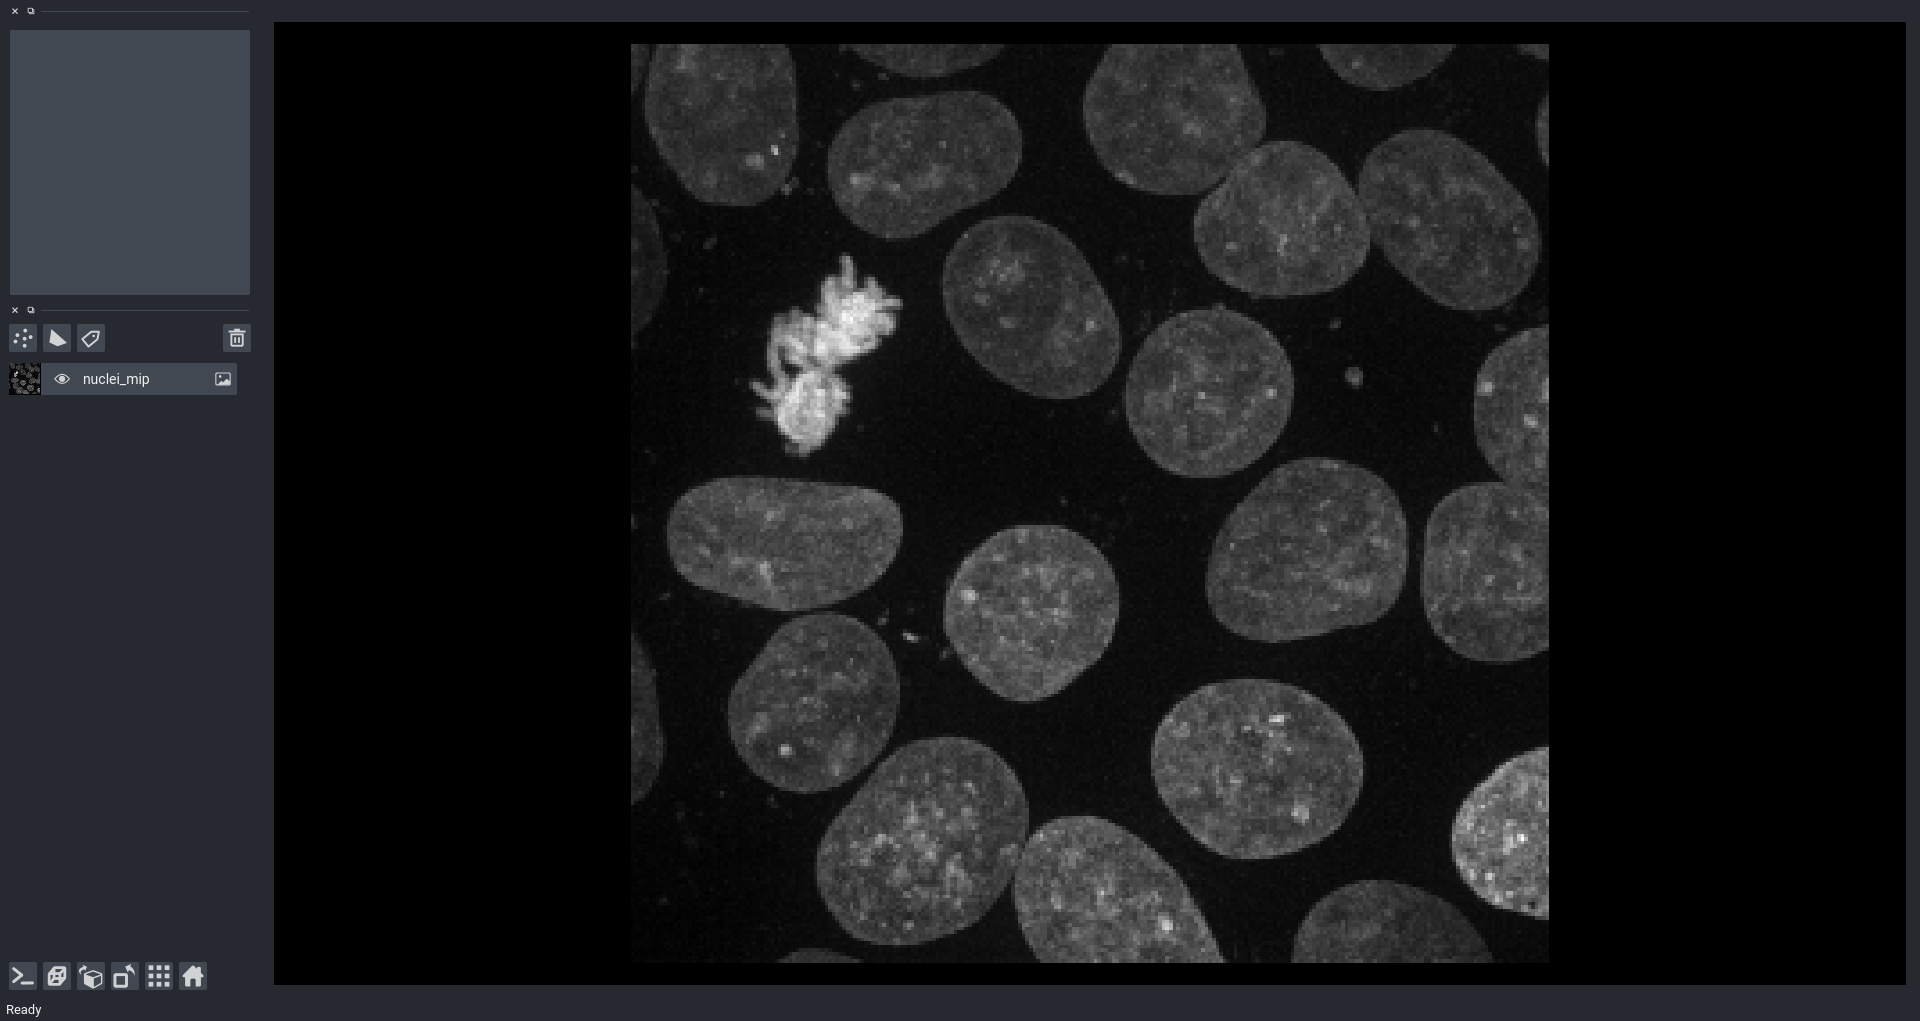

In [31]:
nbscreenshot(viewer)

In [32]:
# Add an empty labels layer
viewer.add_labels(np.zeros(nuclei_mip.shape), name='nuclei segmentation');

In [33]:
# Bind another keybinding to complete segmentation
@viewer.bind_key('Shift-S')
def complete_segmentation(viewer):
    foreground = viewer.layers['threshold result'].data
    distance = ndimage.distance_transform_edt(foreground)
    smoothed_distance = filters.gaussian(distance, 10)
    peak_local_max = feature.peak_local_max(
        smoothed_distance,
        footprint=np.ones((7, 7), dtype=np.bool),
        indices=False,
        labels=measure.label(foreground)
    )
    peaks = np.nonzero(peak_local_max)
    seeds = np.zeros(smoothed_distance.shape, dtype=bool)
    seeds[(peaks[0], peaks[1])] = 1

    markers = measure.label(seeds)
    nuclei_segmentation = segmentation.watershed(
        -smoothed_distance, 
        markers, 
        mask=foreground
    )
    viewer.layers['nuclei segmentation'].data = nuclei_segmentation

In [ ]:
nbscreenshot(viewer)

## Conclusions

We've now seen how to interactively perform analyses by adding data to the napari viewer, and editing it as we moved through an analysis workflow. We've also seen how to extend the viewer with custom GUI functionality and keybindings, making analyses even more interactive!